In [2]:
import sys

sys.path.append('C:\\Users\\erik_\\Documents\\erik documents\\Programas\\PlasmaSimulations\\src')
# sys.path.append('...\\PlasmaSimulations\\src') # Replace dots with personal directory


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from scipy import integrate

import seaborn as sb
import time

import VlasovSolver # Import Vlasov Solver Module

# TECHNISCHE UNIVERSITÄT MÜNCHEN - Sonnendrücker & Possanner Lectures

### 1D-1V Vlasov-Poisson

Solve the Vlasov - Poisson system of electrons:

$$\frac{\partial f}{\partial t} + v \frac{\partial f}{\partial x} - E\frac{\partial f}{\partial v} = 0, \\
- \frac{\partial^2\phi}{\partial x^2} = 1 - \int f dv, \space \space \space \space \space \space  E = -\frac{\partial \phi}{\partial x}$$

Here, $f > 0$ is a function of $t ∈ [0, T]$, $x ∈ [0, L_x]$ and $v ∈ [v_{min}, v_{max}]$, $v_{min} < 0 < v_{max}$, assumed $L_x$-periodic and $(v_{max} − v_{min})$-periodic, respectively, and $\phi = \phi(t, x)$ is $L_x$-periodic.

#### First order splitting:

$$ \frac{d}{dt}u = F u $$
$F$ can be split into $F_1$ and $F_2$. So we have:
$$ \frac{d}{dt}u = (F_1 + F_2) u $$

Let $u_n \approx u(t_n)$
$$ \frac{d}{dt}u^* = F_1(t,u^*(t)) \space \space \space \space for \space \space t_n<t\leq t_{n+1}, \space \space u^*(t_n)=u_n $$
$$ \frac{d}{dt}u^{**} = F_2(t,u^{**}(t)) \space \space \space \space for \space \space t_n<t\leq t_{n+1}, \space \space u^{**}(t_n)=u^*(t_{n+1}) $$
$$ u_{n+1} = u^{**}(t_{n+1})  $$

### Step 1:

Solve Poisson Equation: 
$$ - \frac{\partial^2\phi}{\partial x^2} = 1 - \int f dv$$

### Step 2:

Solve Electric Field Equation: 
$$ E = -\frac{\partial \phi}{\partial x}$$

### Step 3:

Solve the Vlasov equation:

$$\frac{\partial f}{\partial t} + v \frac{\partial f}{\partial x} - E\frac{\partial f}{\partial v} = 0$$

Method: Splitting Method

Step 1: Solve the advection equation in the velocity space

$$ (A): \frac{\partial f^*}{\partial t} - E\frac{\partial f^*}{\partial v} = 0 \\
f^*(t_n) = f(t_n)$$

Step 2: Solve the advection equation in the positions space

$$ (B): \frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} = 0 \\
f(t_n) = f^*(t_{n+1})$$


In [3]:
def error_func(y1,y2):
    '''Calculate the difference between to arrays'''
    y1 = np.array(y1)
    y2 = np.array(y2)
    if np.array(y1).shape == np.array(y2).shape:
        diff = y1-y2
        return diff
    else:
        print('Arrays must have the same dimension')

In [4]:
def calculate_norm(vector,norm_number):
    '''vector: Array or vector to which you want to determine the norm: 1,2 or inf
       norm_number: Norm order'''
    if type(norm_number) == str:
        return np.linalg.norm(vector,ord = float(norm_number))
    else:
        return np.linalg.norm(vector , ord = norm_number)

In [5]:
# Define variables 
L_x = 12 # Longitude
v_min = -5 # Minimum Velocity 
v_max = 5 # Maximum Velocity 
T_max = 30 # Max time

In [6]:
# Initial Condition
def initial_cond(x,v):
    return (1.0 + 0.01 * np.cos(2*np.pi*x/L_x)) * (1.0/(2.0*np.pi)**(1/2)) * np.exp(-v**2/2)

In [7]:
N_x = 80 # Position Slots 
N_y = 105 # Velocities Slots 
M_size = 1050 # Divisions of time in M slots 

# Step Sizes:
dx = L_x/N_x
dv = (v_max-v_min)/N_y
dt = T_max/M_size

print(f'Nx: {N_x}     dx: {dx}')
print(f'Ny: {N_y}    dy: {dv}')
print(f'M:  {M_size}   dt: {dt}')

Nx: 80     dx: 0.15
Ny: 105    dy: 0.09523809523809523
M:  1050   dt: 0.02857142857142857


### Numerical Experiment 1: Testing the difference between advection schemes

Solve the Vlasov-Poisson system for the 3 different advection schemes with fixed dx,dv and dt. Consider the first order splitting method.

In [8]:
Split_Methods = ['Lax Wendroff','Spectral'] # Define the 3 advection schemes to evaluate

In [10]:
solutions_dict = {'Mass':[],'Moment':[],'Energy':[],'L2norm':[]} #Dictionary to store the solution for each parameter
for Split_Method in Split_Methods:
    # Iterate over the splitting methods
    print(Split_Method)
    # Create object with split order = 1
    objectSolver =  VlasovSolver.VlasovPoisson1D1V(initial_cond, 0.0, L_x, N_x, v_min, v_max, N_y , T_max, M_size,
                                            Split_Method,1,'Vlasov1')
    Mass_Sol,Moment_Sol,Energy_Sol,L2norm_Sol,Ef = objectSolver.run_iteration() # Run model
    
    # Store solutions for each conservation quantity
    solutions_dict['Mass'].append(Mass_Sol)
    solutions_dict['Moment'].append(Moment_Sol)
    solutions_dict['Energy'].append(Energy_Sol)
    solutions_dict['L2norm'].append(L2norm_Sol)

t_grid = objectSolver.grid_points(0.0,T_max,dt)[:-1] # Save the time grid to plot results

Lax Wendroff
Spectral


In [11]:
x_grid = objectSolver.grid_points(0.0, L_x, dx)
v_grid = objectSolver.grid_points(v_min,v_max, dv)

Pos,Vel = np.meshgrid(x_grid,v_grid)

In [18]:
def plot_quantities(dictionary_sol,splitting_methods,time_g, variable,dif_t):
    ''' Function to plot a quantity for the n different numerical schemes '''
    plt.figure(figsize=(10,8))
    for quant,method in zip(dictionary_sol,splitting_methods):
        plt.plot(time_g , quant/quant[0] ,label = method)
    plt.title(f"Conservation of Total {variable} for dt: "+ "%.3f"%dif_t,fontsize=15)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel(f'{variable}',fontsize=14)
    plt.legend()
    plt.show()

Conservation of total mass:
$$ \frac{d\text{M}}{dt}=\frac{d}{dt}\int f d\textbf{x}d\textbf{v}=0 $$

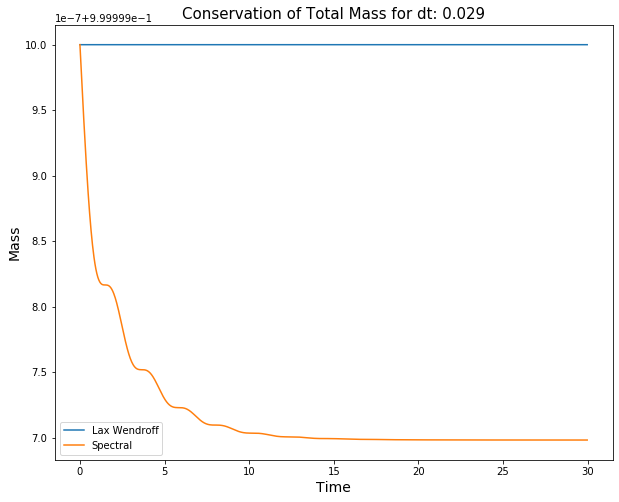

In [19]:
plot_quantities(solutions_dict['Mass'],Split_Methods,t_grid,'Mass',dt)

Conservation of total momentum:
$$ \frac{d\textbf{P}}{dt}=\frac{d}{dt}\int \textbf{v} f d\textbf{x}d\textbf{v}=0 $$

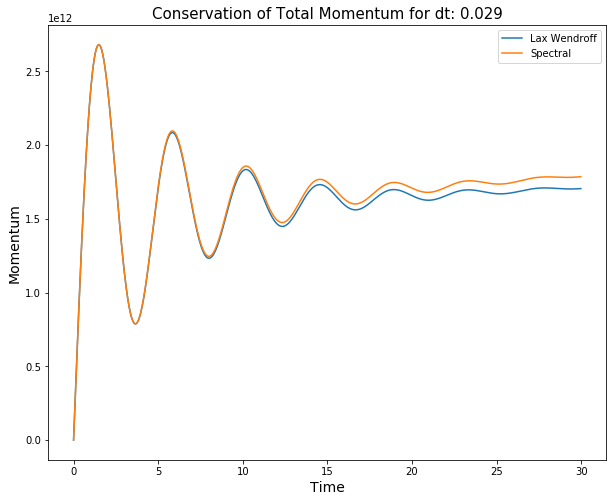

In [24]:
plot_quantities(solutions_dict['Moment'],Split_Methods,t_grid,'Momentum',dt)

Conservation of total energy:
$$  \frac{d \varepsilon}{dt} =  \frac{d}{dt} \bigg[ \frac{1}{2} \int v^2 f d\textbf{x}d\textbf{v} + \frac{1}{2} \int \textbf{E}^2 d\textbf{x} \bigg] =0$$

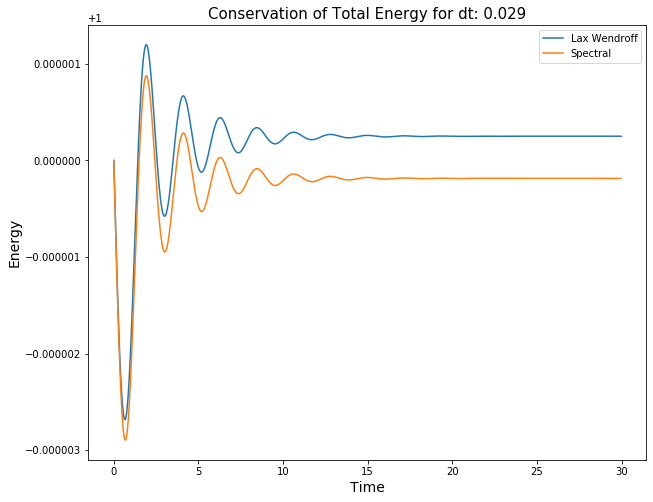

In [25]:
plot_quantities(solutions_dict['Energy'],Split_Methods,t_grid,'Energy',dt)

Conservation of $L^2$ norm:
$$ \frac{d}{dt}\int f^2 d\textbf{x}d\textbf{v}=0 $$

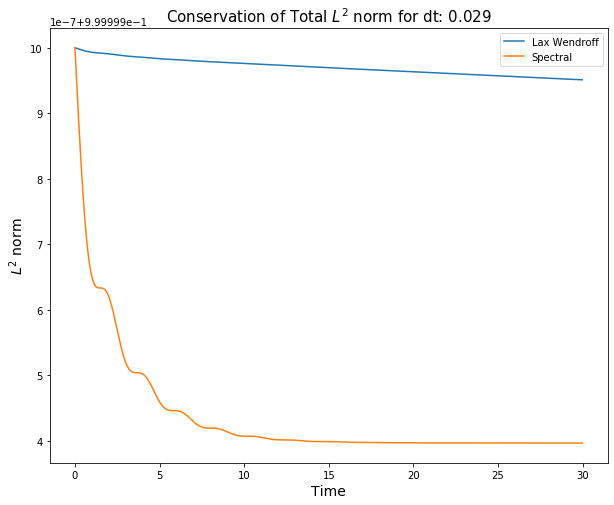

In [27]:
plot_quantities(solutions_dict['L2norm'],Split_Methods,t_grid,'$L^2$ norm',dt)

### Numerical Experiment 2: Testing the difference between advection schemes and the difference between splitting orders

Solve the Vlasov-Poisson system for the 3 different advection schemes with fixed dx,dv and dt. Consider the first and second order splitting methods.

In [31]:
solutions_dict2 = {'Mass':[],'Moment':[],'Energy':[],'L2norm':[]}
for Split_Method in Split_Methods:
    # Create object with split order = 2
    objectSolver2 =  VlasovSolver.VlasovPoisson1D1V(initial_cond,0.0, L_x, N_x, v_min, v_max, N_y , T_max, M_size,
                                            Split_Method,2,'Vlasov1')
    Mass_Sol2,Moment_Sol2,Energy_Sol2,L2norm_Sol2,Ef = objectSolver2.run_iteration() # Run model
    
    # Store solutions for each conservation quantity
    solutions_dict2['Mass'].append(Mass_Sol2)
    solutions_dict2['Moment'].append(Moment_Sol2)
    solutions_dict2['Energy'].append(Energy_Sol2)
    solutions_dict2['L2norm'].append(L2norm_Sol2)
t_grid2 = objectSolver2.grid_points(0.0,T_max,dt)[:-2]

In [32]:
def plot_quantities_order(dictionary_sol1, dictionary_sol2 , splitting_methods,time_g, variable,dif_t):
    ''' Function to plot a quantity for the 3 different numerical schemes and for order 1 and 2'''
    plt.figure(figsize=(10,8))
    colors = ['tab:blue','tab:orange','tab:green']
    for mass1,mass2,method,col in zip(dictionary_sol1,dictionary_sol2,splitting_methods,colors):
        plt.plot(time_g,mass1/mass1[0],label = method + ' Order 1',color=col)
        plt.plot(time_g,mass2/mass2[0],'--',label = method + ' Order 2',color=col)
    plt.title(f"Conservation of Total {variable} for dt: "+ "%.3f"%dif_t,fontsize=15)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel(f'{variable}',fontsize=14)
    plt.legend()
    plt.show()

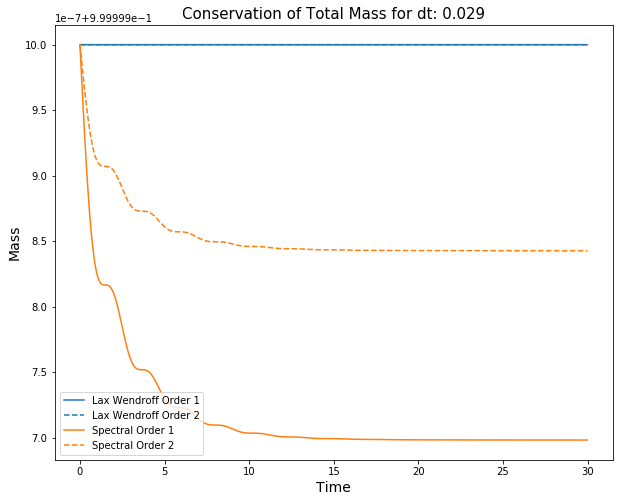

In [33]:
plot_quantities_order(solutions_dict['Mass'],solutions_dict2['Mass'],Split_Methods,t_grid,'Mass',dt)

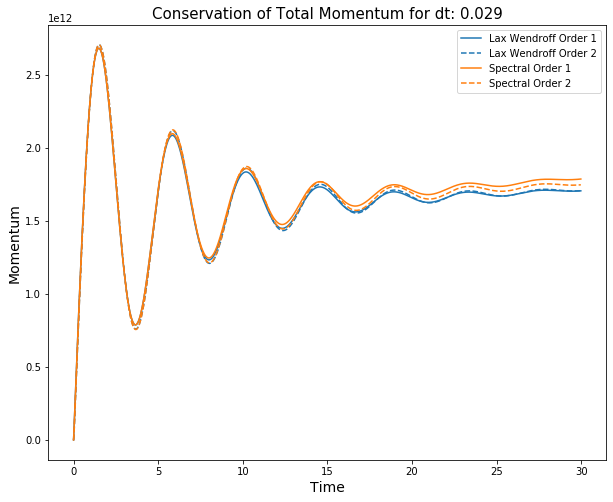

In [34]:
plot_quantities_order(solutions_dict['Moment'],solutions_dict2['Moment'],Split_Methods,t_grid,'Momentum',dt)

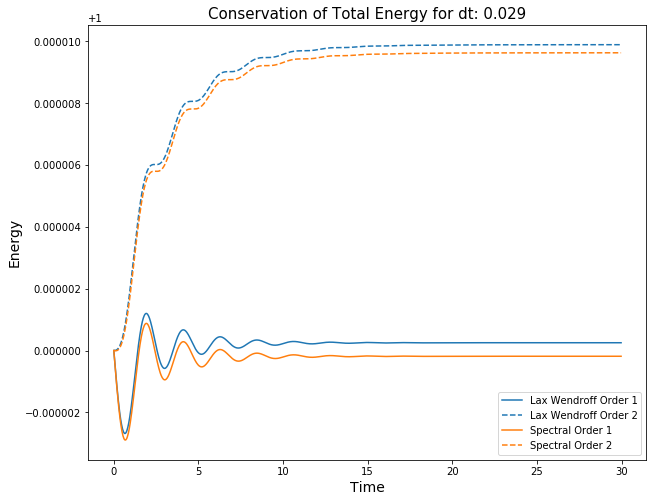

In [35]:
plot_quantities_order(solutions_dict['Energy'],solutions_dict2['Energy'],Split_Methods,t_grid,'Energy',dt)

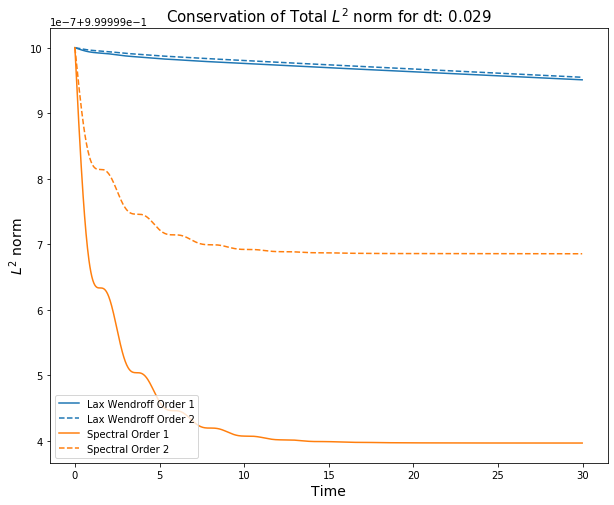

In [36]:
plot_quantities_order(solutions_dict['L2norm'],solutions_dict2['L2norm'],Split_Methods,t_grid,'$L^2$ norm',dt)

### Numerical Experiment 3: Test the difference between advection schemes and different spatial distribution values (vary dx and dv) and different time steps (vary dt)

Solve the Vlasov-Poisson system for the 3 different advection schemes with different dx,dv and dt. Consider only the first order splitting method.

In [22]:
factors = np.array([1,1.5,2,2.6,3.5]) # Factors to multiply the divisions
factors2 = np.array([1,1.55,2.1,2.7,3.6])

In [23]:
N_x_vector = (factors*80).astype(int) # Position Slots 
N_y_vector = (factors*105).astype(int) # Velocities Slots 
M_size_vector = (factors2*1000).astype(int) # Divisions of time in M slots 

# Step Sizes:
dxs = L_x/N_x_vector
dvs = (v_max-v_min)/N_y_vector
dts = T_max/M_size_vector

print('dx: ',dxs)
print('Nx Vector: ',N_x_vector)
print('')
print('dv: ',dvs)
print('Ny Vector: ',N_y_vector)
print('')
print('dt: ',dts)
print('M Vector: ',M_size_vector)

dx:  [0.15       0.1        0.075      0.05769231 0.04285714]
Nx Vector:  [ 80 120 160 208 280]

dv:  [0.0952381  0.06369427 0.04761905 0.03663004 0.02724796]
Ny Vector:  [105 157 210 273 367]

dt:  [0.03       0.01935484 0.01428571 0.01111111 0.00833333]
M Vector:  [1000 1550 2100 2700 3600]


In [24]:
start_time = time.time()
Solutions_Split = {'Lax Wendroff':{},'Euler Upwind':{},'Spectral':{}} # Dictionary to store the 3 numerical schemes solutions
for Split_Method in Split_Methods:
    # Iterate over the 3 numerical schemes
    
    solutions_Method = {'Mass':[],'Moment':[],'Energy':[],'L2norm':[],'Times':[]} # create auxiliary dictionary to store 
                                                                                  # the 4 quantities
    
    for i in range(len(factors)):
        # Iterate over the different spatial and time distributions for order 1
        objSolver = VlasovSolver.VlasovPoissonSystem1D1V(initial_cond, L_x,N_x_vector[i], v_min, v_max, N_y_vector[i] , T_max, 
                                            M_size_vector[i], Split_Method, 1 ,'Vlasov1')
        Mass_sol,Moment_sol,Energy_sol,L2norm_sol,Ef = objSolver.run() # run model
        
        # Save the 4 conservation quantities
        solutions_Method['Mass'].append(Mass_sol)
        solutions_Method['Moment'].append(Moment_sol)
        solutions_Method['Energy'].append(Energy_sol)
        solutions_Method['L2norm'].append(L2norm_sol)
    
        # Save the time division values
        dtimes = T_max/M_size_vector[i]
        time_grid = objSolver.grid_points(0.0,T_max,dtimes)
        solutions_Method['Times'].append(time_grid)
    
    Solutions_Split[Split_Method] = solutions_Method # Save the solutions for the ith Advection scheme

end_time = time.time()
print('Total execution time: ',(end_time-start_time)/60.)

Total execution time:  57.15980468988418


Plots for Lax Wendroff Scheme:

In [57]:
def plot_quantities2(sol_vec,time_vec,method_name,dif_t_vec,variable_name):
    plt.figure(figsize=(10,8))
    for solu,t_v,dt_label in zip(sol_vec,time_vec,dif_t_vec):
        if solu[0] >= 0.0000000001:
            plt.plot(t_v,solu/solu[0],label = 'dt: ' + "%.3f"%dt_label)
        else:
            plt.plot(t_v,solu,label = 'dt: ' + "%.3f"%dt_label)
    plt.title(f"Conservation of Total {variable_name} for {method_name}",fontsize=15)
    plt.xlabel('Time',fontsize=14)
    plt.ylabel(f'{variable_name}',fontsize=14)
    plt.legend()
    plt.show()

In [58]:
time_vectors = Solutions_Split['Lax Wendroff']['Times'].copy()
time_vectors[0] = time_vectors[0][:-2]
time_vectors[1] = time_vectors[1][:-1]
time_vectors[2] = time_vectors[2][:-1]
time_vectors[3] = time_vectors[3][:-1]
time_vectors[4] = time_vectors[4][:-1]

In [59]:
for t in time_vectors:
    print(t.shape)

(1000,)
(1550,)
(2100,)
(2700,)
(3600,)


In [60]:
for m in Solutions_Split['Lax Wendroff']['Mass']:
    print(np.array(m).shape)

(1000,)
(1550,)
(2100,)
(2700,)
(3600,)


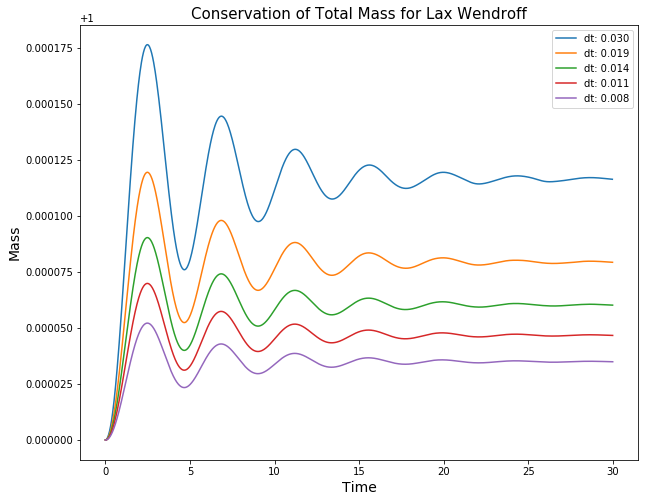

In [61]:
plot_quantities2(Solutions_Split['Lax Wendroff']['Mass'],time_vectors,'Lax Wendroff',dts,'Mass')

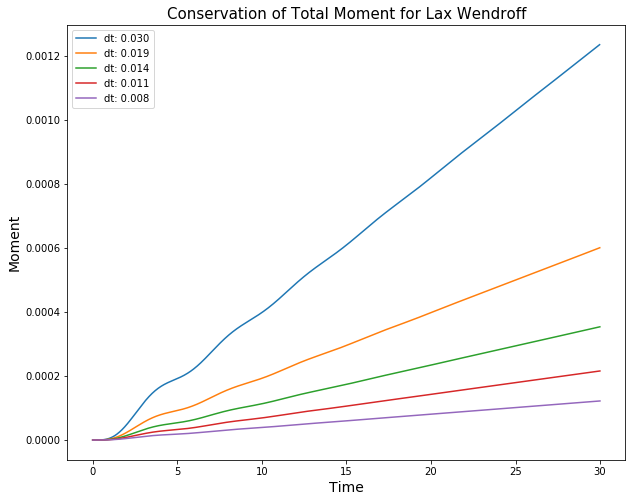

In [62]:
plot_quantities2(Solutions_Split['Lax Wendroff']['Moment'],time_vectors,'Lax Wendroff',dts,'Moment')

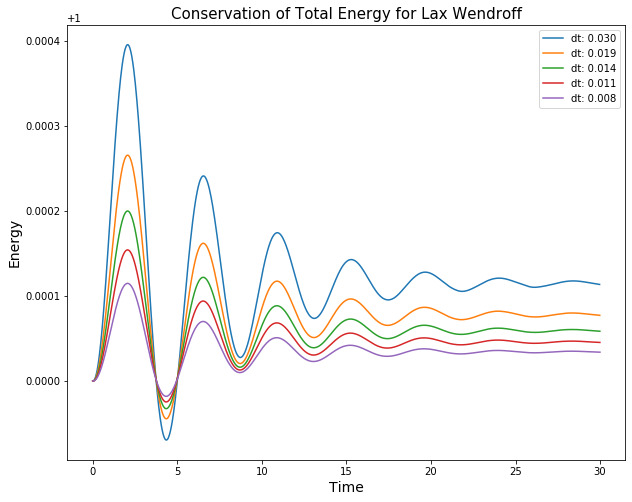

In [63]:
plot_quantities2(Solutions_Split['Lax Wendroff']['Energy'],time_vectors,'Lax Wendroff',dts,'Energy')

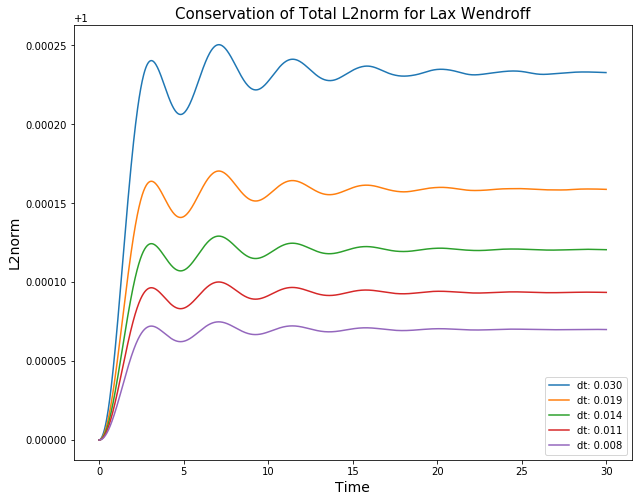

In [64]:
plot_quantities2(Solutions_Split['Lax Wendroff']['L2norm'],time_vectors,'Lax Wendroff',dts,'L2norm')

Plots for Euler Upwind Scheme:

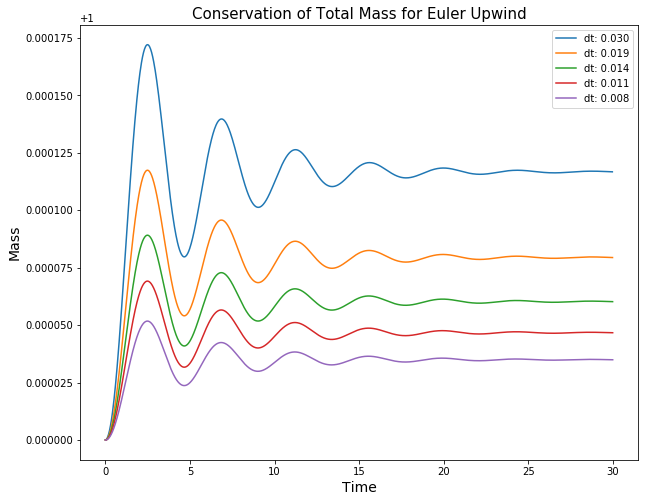

In [65]:
plot_quantities2(Solutions_Split['Euler Upwind']['Mass'],time_vectors,'Euler Upwind',dts,'Mass')

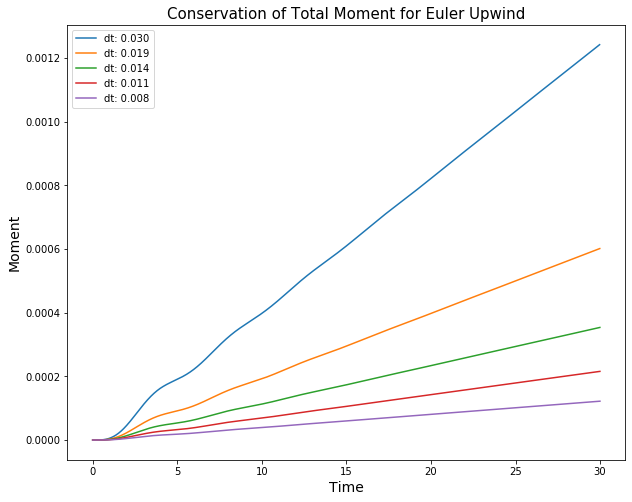

In [66]:
plot_quantities2(Solutions_Split['Euler Upwind']['Moment'],time_vectors,'Euler Upwind',dts,'Moment')

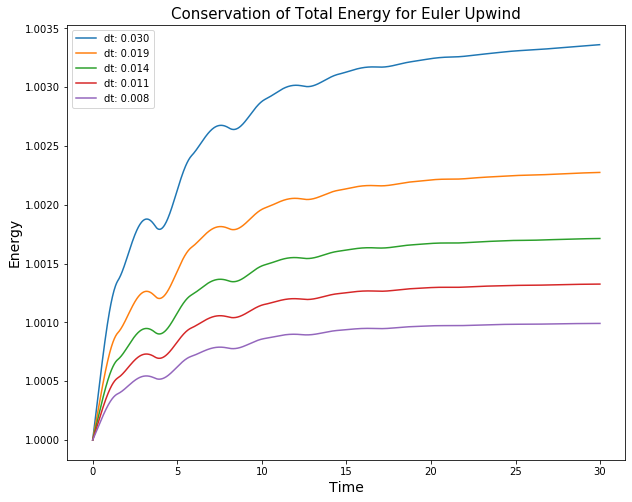

In [67]:
plot_quantities2(Solutions_Split['Euler Upwind']['Energy'],time_vectors,'Euler Upwind',dts,'Energy')

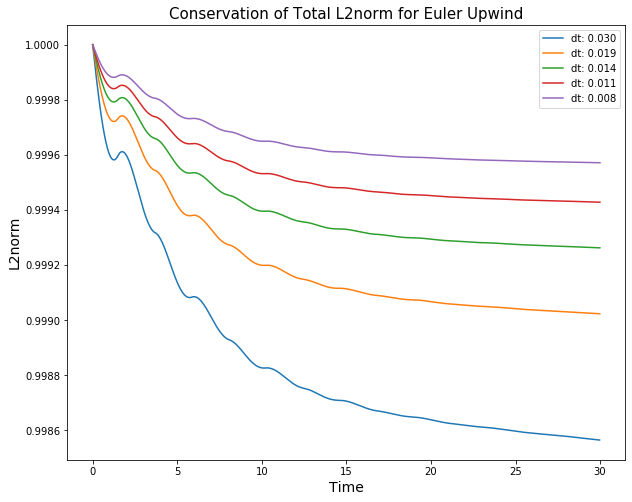

In [68]:
plot_quantities2(Solutions_Split['Euler Upwind']['L2norm'],time_vectors,'Euler Upwind',dts,'L2norm')

Plots for Spectral Scheme:

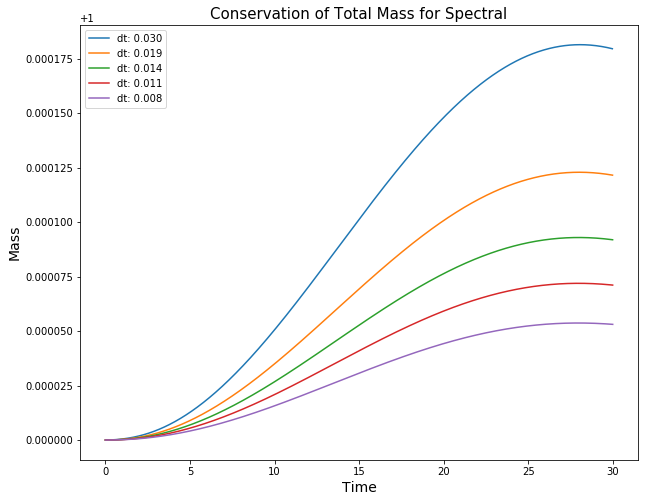

In [69]:
plot_quantities2(Solutions_Split['Spectral']['Mass'],time_vectors,'Spectral',dts,'Mass')

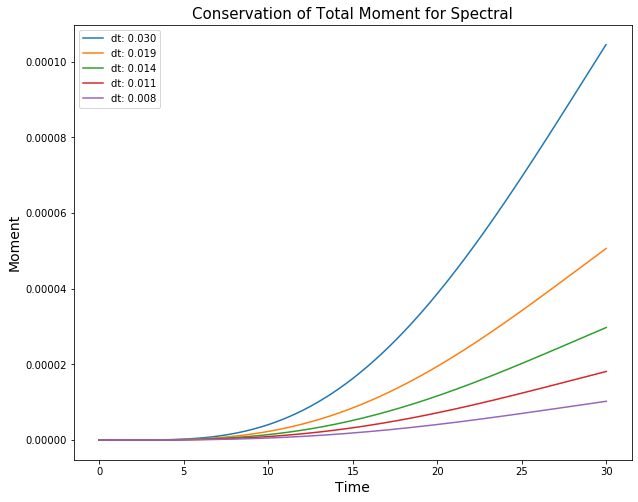

In [70]:
plot_quantities2(Solutions_Split['Spectral']['Moment'],time_vectors,'Spectral',dts,'Moment')

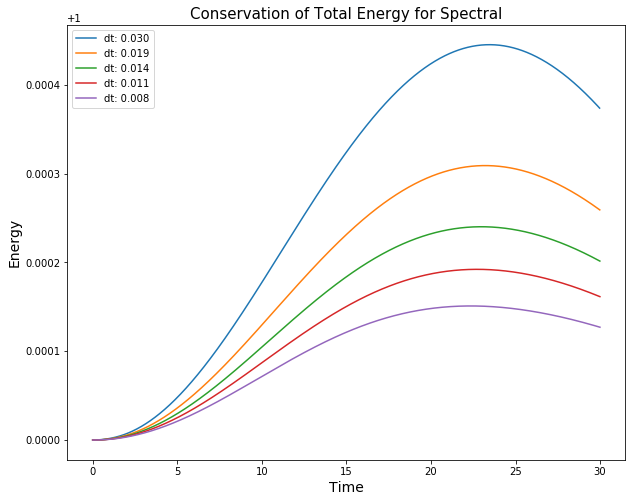

In [71]:
plot_quantities2(Solutions_Split['Spectral']['Energy'],time_vectors,'Spectral',dts,'Energy')

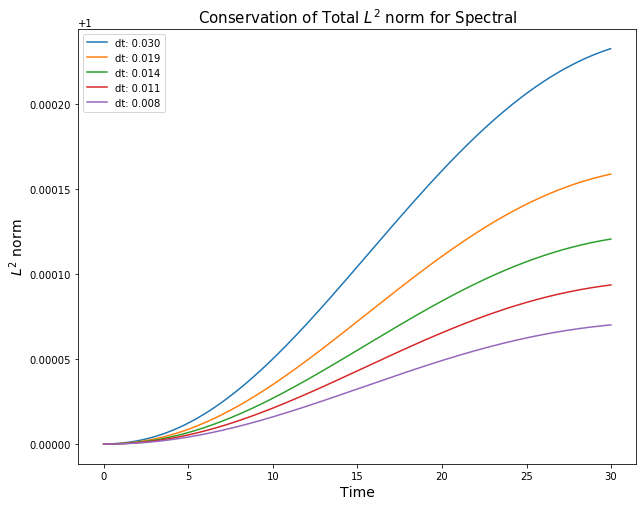

In [72]:
plot_quantities2(Solutions_Split['Spectral']['L2norm'],time_vectors,'Spectral',dts,'$L^2$ norm')